If you are executing from Google Colab please execute this cell

In [ ]:
!pip install fastai==2.5.2

Importing necessary libraries

In [ ]:
from fastai.vision.all import *

Early stopping configuration

In [2]:
fname="classification"
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="f1_score"
comp_evaluating=np.greater

patience=2

# Dataloaders

At this step we defined the function to obtain the label of the image (`label_func`) and the function used to
get val and train splits (`ParentSplitter`). 

After that we use FastAI [DataBlock API](https://docs.fast.ai/tutorial.datablock.html) to define our DataLoader

In [3]:
path_img = 'split_ocean_elements'

def label_func(fname):
    return str(fname).split('/')[-2]

fnames= get_image_files(path_img)

def ParentSplitter(x):
    return Path(x).parent.parent.name=='val'

class CropTransform(RandTransform):
    split_idx= None
    def __init__(self): 
        super().__init__()
    def encodes(self, x: Image.Image):
        return x.crop((634, 0, 3206, 2160))

datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=FuncSplitter(ParentSplitter),
    get_y=label_func,
    item_tfms=[CropTransform(),Resize(512)],
    batch_tfms=[Normalize.from_stats(*imagenet_stats),
                Dihedral(p=.3,draw=1),Rotate(p=.3), Brightness(p=.6), Contrast(p=.6)])

In [4]:
dls = datablock.dataloaders(path_img, bs=10)

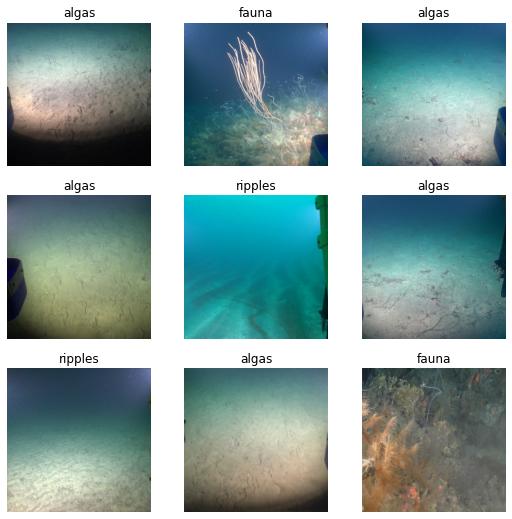

In [5]:
dls.show_batch()

# Learner

We create a CNN for classification using a pretrained resnet34 in ImageNet as backbone.

We use F1Score as our evaluation metric, it is important to note that we are using `average='weighted'` as our dataset is imbalanced.

We also use FP16 for training

In [6]:
learn = cnn_learner(dls, arch=models.resnet34, metrics = [F1Score(average='weighted')],
                        pretrained=True, loss_func = CrossEntropyLossFlat()).to_fp16()
learn.freeze()

/home/david/anaconda3/envs/datathon/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-eoxszjt0/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Searching for the optional Learning Rate

/home/david/anaconda3/envs/datathon/lib/python3.7/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0012022644514217973)

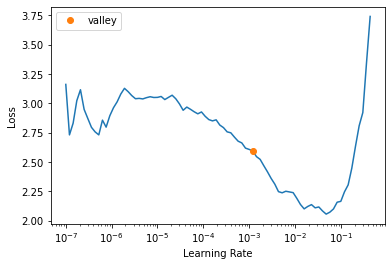

In [7]:
learn.lr_find()

We train last layers with EarlyStopping

epoch,train_loss,valid_loss,f1_score,time
0,0.733969,0.357457,0.916029,01:01
1,0.786090,0.418040,0.937994,01:00
2,0.726815,0.423634,0.900911,01:00
3,0.536296,0.216918,0.965649,01:00
4,0.411610,0.216205,0.951923,01:01
5,0.383980,0.158887,0.961498,01:02


Better model found at epoch 0 with f1_score value: 0.9160293553146072.


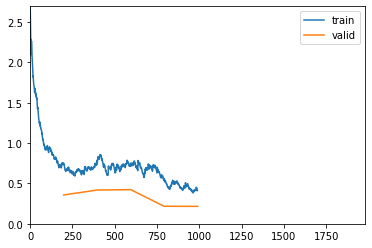

Better model found at epoch 1 with f1_score value: 0.9379939265165947.
Better model found at epoch 3 with f1_score value: 0.9656486873356144.
No improvement since epoch 3: early stopping


In [8]:
fname='elements-before-unfreeze'
callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2), cbs=callbacksFitBeforeUnfreeze)

We unfreeze the full model and search again for an optimal learning rate

/home/david/anaconda3/envs/datathon/lib/python3.7/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=1.2022644114040304e-05)

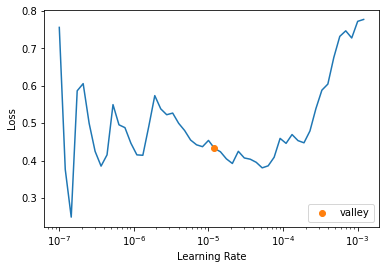

In [10]:
learn = cnn_learner(dls, arch=models.resnet34, metrics = [F1Score(average='weighted')],
                        pretrained=True, loss_func = CrossEntropyLossFlat()).to_fp16()
learn.load('elements-before-unfreeze')
learn.unfreeze()
learn.lr_find()

Now we train the full model with a smaller learning rate

epoch,train_loss,valid_loss,f1_score,time
0,0.403560,0.184352,0.963594,01:01
1,0.321929,0.194827,0.963562,01:01
2,0.265905,0.179500,0.963576,01:02


Better model found at epoch 0 with f1_score value: 0.963594069600582.


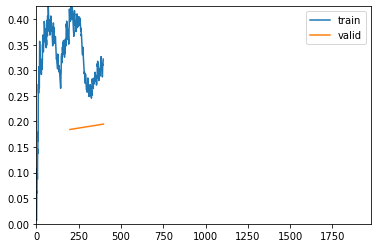

No improvement since epoch 0: early stopping


In [11]:
fname='elements-after-unfreeze'
callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(3e-6,2e-5), cbs=callbacksFitBeforeUnfreeze)

Evaluation metrics computation

In [12]:
learn = cnn_learner(dls, arch=models.resnet34, metrics = [F1Score(average='weighted')],
                        pretrained=True, loss_func = CrossEntropyLossFlat()).to_fp16()
learn.load('elements-after-unfreeze')
learn.validate()

/home/david/anaconda3/envs/datathon/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#2) [0.18435193598270416,0.963594069600582]

We export the model to be usable at inference

In [86]:
learn.export('detection-learner.pkl')